In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import time

In [2]:
df_train=pd.read_csv('../Santander - Cust Satisfaction/train.csv')
df_test=pd.read_csv('../Santander - Cust Satisfaction/test.csv')

In [3]:
# Data summary
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)
print(df_train.TARGET.value_counts(normalize=True))
# Imbalanced classes! Only 4% target values..

('df_train.shape:', (76020, 371))
('df_test.shape:', (75818, 370))
0    0.960431
1    0.039569
Name: TARGET, dtype: float64


In [4]:
desc=df_train.describe()
desc.loc['unique']=[len(df_train[i].unique()) for i in df_train.columns]
desc=desc.T

desc.to_csv('data_summary.csv')
# Some features have unique col = 0, some features have max col = 9999999999 (maybe outlier values)
desc

,count,mean,std,min,25%,50%,75%,max,unique
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00,76020.0
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00,208.0
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00,100.0
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00,596.0
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03,7551.0
imp_op_var39_comer_ult3,76020.0,119.529632,546.266294,0.00,0.0000,0.00,0.0000,21024.81,9099.0
imp_op_var40_comer_ult1,76020.0,3.559130,93.155749,0.00,0.0000,0.00,0.0000,8237.82,293.0
imp_op_var40_comer_ult3,76020.0,6.472698,153.737066,0.00,0.0000,0.00,0.0000,11073.57,346.0
imp_op_var40_efect_ult1,76020.0,0.412946,30.604864,0.00,0.0000,0.00,0.0000,6600.00,23.0
imp_op_var40_efect_ult3,76020.0,0.567352,36.513513,0.00,0.0000,0.00,0.0000,6600.00,29.0


# Data Preprocessing

In [5]:
# Remove duplicated columns
remove=[]

cols=df_train.columns
for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        if np.array_equal(df_train[cols[i]].values, df_train[cols[j]].values):
            remove.append(cols[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

In [6]:
print "Columns to be removed:", len(set(remove))
print df_train.shape
print df_test.shape

Columns to be removed: 62
(76020, 309)
(75818, 308)


In [7]:
for col in df_train.columns:
    df_train[col].std()

In [8]:
# Remove constant columns (std=0)
remove=[]

for col in df_train.columns:
    if df_train[col].std()==0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

In [9]:
print "Columns removed due to constant variance:", len(set(remove))
print df_train.shape
print df_test.shape

Columns removed due to constant variance: 1
(76020, 308)
(75818, 307)


In [10]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [11]:
# Split data in train and test
X=df_train.drop(['ID','TARGET'], axis=1)
y=df_train.TARGET.values

test_id=df_test.ID
test=df_test.drop(['ID'], axis=1)

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=0)

print(X_train.shape)

(60816, 306)


In [12]:
# Model selection
def score_model(clf):
    print ("model: {} ...".format(clf.__class__.__name__))
    start = time.time()
    scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=3) 
    end = time.time()
    print("time: {:.3f}s".format(end - start))
    print("roc_auc: {:.3f}\n".format(scores.mean()))

In [13]:
score_model(DecisionTreeClassifier())
score_model(GaussianNB())
score_model(LogisticRegression())
score_model(RandomForestClassifier())
score_model(XGBClassifier())

model: DecisionTreeClassifier ...
time: 5.011s
roc_auc: 0.572

model: GaussianNB ...
time: 1.885s
roc_auc: 0.515

model: LogisticRegression ...
time: 2.539s
roc_auc: 0.606

model: RandomForestClassifier ...
time: 3.057s
roc_auc: 0.683

model: XGBClassifier ...
time: 14.667s
roc_auc: 0.836



In [14]:
# Feature selection
clf=XGBClassifier()

clf.fit(X_train,y_train)

importances=clf.booster().get_fscore()

df_importance=pd.Series(list(importances.values()), index=list(importances.keys()))
df_importance.sort_values(inplace=True, ascending=False)

<bound method AxesSubplot.invert_yaxis of <matplotlib.axes._subplots.AxesSubplot object at 0x11b2c1f50>>

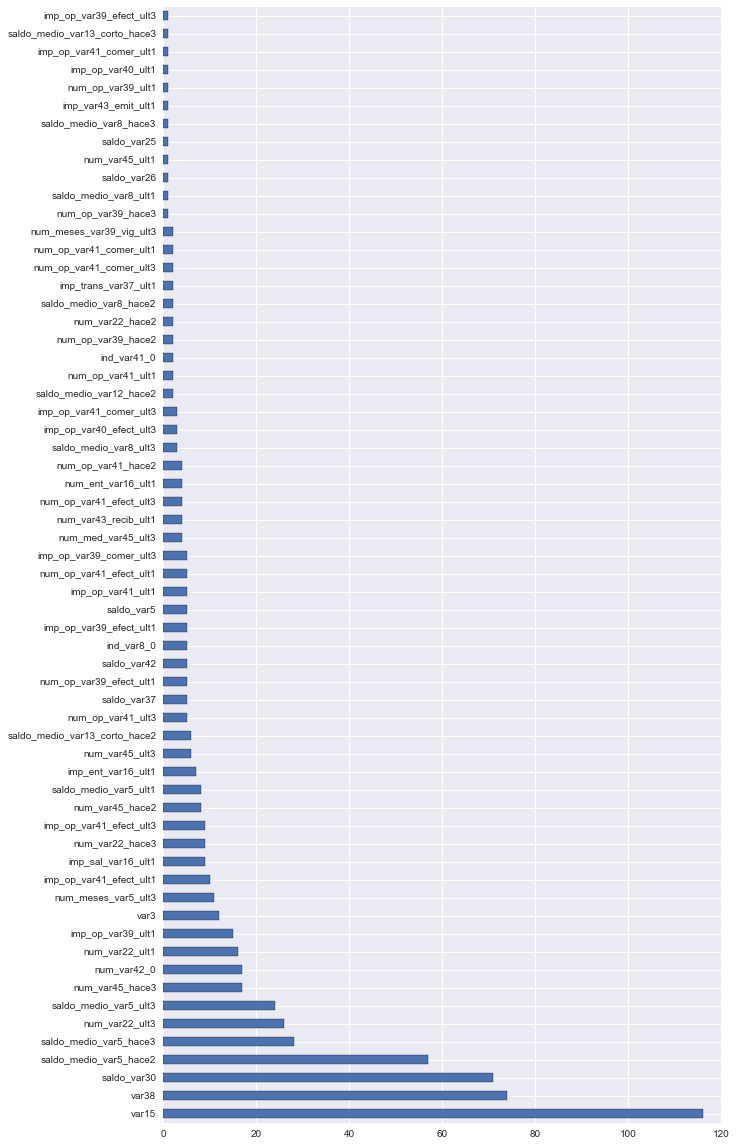

In [15]:
# Top importance features
ax=df_importance.head(100).plot(kind='barh', figsize=(10,20))
ax.invert_yaxis

In [16]:
X_train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
39926,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130119.36
28569,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247015.23
36753,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106671.21
46226,2,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90184.86
67626,2,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63649.02


(array([   127.,  21961.,  17583.,  10521.,   5761.,   2760.,   1245.,
           564.,    264.,     30.]),
 array([   5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,
          95.,  105.]),
 <a list of 10 Patch objects>)

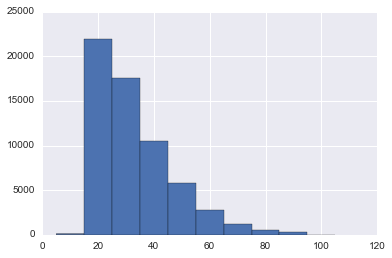

In [17]:
#Looks like age variable
plt.hist(X_train["var15"], bins=10)

In [18]:
age_sat = pd.concat([df_train.groupby("var15")["TARGET"].agg({'TARGET' : 'sum'}),df_train.groupby("var15")["TARGET"].agg({'TARGET' : 'count'})],axis=1).reset_index()

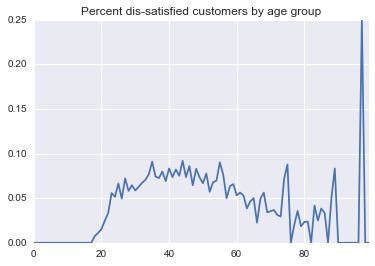

In [19]:
age_sat.columns = ["var15", "Dis_sat_cust","Total_cust"]
age_sat["Pct_dis_sat_cust"] = age_sat["Dis_sat_cust"] / (age_sat["Total_cust"])
age_sat["Pct_dis_sat_cust"].plot()
plt.title("Percent dis-satisfied customers by age group")

(array([  1.80000000e+01,   7.62000000e+02,   1.22300000e+04,
          3.77200000e+04,   8.72100000e+03,   1.18500000e+03,
          1.43000000e+02,   2.20000000e+01,   1.10000000e+01,
          4.00000000e+00]),
 array([  8.54941834,   9.38528958,  10.22116083,  11.05703208,
         11.89290332,  12.72877457,  13.56464582,  14.40051706,
         15.23638831,  16.07225955,  16.9081308 ]),
 <a list of 10 Patch objects>)

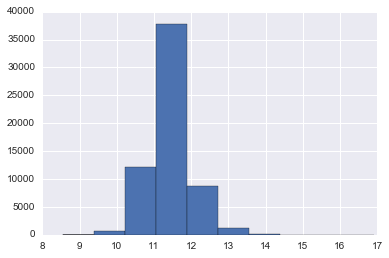

In [20]:
plt.hist(np.log(X_train["var38"]))

/Users/ipm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(array([ 31750.,   3116.,   3567.,   8359.,   4102.,   3319.,   1773.,
          2554.,   2203.,     73.]),
 array([ 0.        ,  0.63804877,  1.27609755,  1.91414632,  2.5521951 ,
         3.19024387,  3.82829264,  4.46634142,  5.10439019,  5.74243897,
         6.38048774]),
 <a list of 10 Patch objects>)

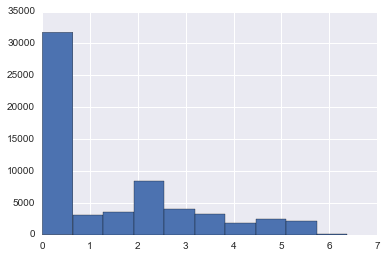

In [21]:
X_train.loc[X_train["saldo_var30"] <= 1, "saldo_var30"] = 1
plt.hist(np.log10(X_train["saldo_var30"]))

In [22]:
X_train["saldo_medio_var12_hace3"].nunique()

965

In [16]:
# Tune Max depth and Min child weight
param_test1 = {
 'max_depth':range(5,8,1),
 'min_child_weight':range(1,10,3)
}
estimator = XGBClassifier()
print estimator

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [17]:
gsearch1 = GridSearchCV(estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

In [ ]:
gsearch1.fit(X_train,y_train)

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
## Tune Colsample by tree and subsample rate

In [ ]:
param_test2 = {
 'colsample_bytree':[0.6,0.7,0.8,0.9],
 'subsample':[0.6,0.7,0.8,0.9]
}
estimator2 = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,
 colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
print estimator2

In [ ]:
gsearch2 = GridSearchCV(estimator2, param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

In [ ]:
gsearch2.fit(X_train,y_train)

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
## tune n_estimators parameter

In [ ]:
param_test3 = {
 n_estimators:range(100,1000,100)
}
estimator3 = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,
 colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
print estimator3

In [ ]:
gsearch3 = GridSearchCV(estimator3, param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)

In [ ]:
gsearch3.fit(X_train,y_train)

In [ ]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
## Tune gamma parameter

In [ ]:
param_test4 = {
 gamma:range[0.1,0.25, 0.5, 0.75]
}
estimator4 = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,
 colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
print estimator4

In [ ]:
gsearch4 = GridSearchCV(estimator4, param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)

In [ ]:
gsearch4.fit(X_train,y_train)

In [ ]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
## Tune learning_rate

In [ ]:
param_test5 = {
 learning rate:range[0.1,0.25, 0.5, 0.75]
}
estimator5 = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,
 colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
print estimator5

In [ ]:
gsearch5 = GridSearchCV(estimator5, param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)

In [ ]:
gsearch5.fit(X_train,y_train)

In [ ]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
## Evaluation of the model

In [ ]:
eval_metrics = ['auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]

clf=XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, min_child_weight=4, gamma=0, colsample_bytree=0.7, subsample=0.6, reg_alpha=5e-05, objective='binary:logistic', scale_pos_weight=1, seed=27)

clf.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets)

In [ ]:
# Create submission
y_pred=clf.predict_proba(test)

df_submit=pd.DataFrame({'ID': test_id, 'TARGET': y_pred[:,-1]})
df_submit.to_csv('submission.csv', index=False)

df_submit.head()

In [ ]:
eval_metrics = ['auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]

clf=XGBClassifier(n_estimators=860, learning_rate=0.01, max_depth=5, min_child_weight=1, gamma=0, colsample_bytree=0.6, 
                  subsample=0.6, reg_alpha=5e-05, objective='binary:logistic', scale_pos_weight=1, seed=0)

clf.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets)

In [ ]:
# Create submission
y_pred=clf.predict_proba(test)

df_submit=pd.DataFrame({'ID': test_id, 'TARGET': y_pred[:,-1]})
df_submit.to_csv('submission1.csv', index=False)

df_submit.head()

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1,seed=27), param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
param_test4 = {
 'colsample_bytree':[i/10.0 for i in range(3,8)],
 'subsample':[i/10.0 for i in range(3,8)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1,gamma=0.2, seed=27), param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1,gamma=0.2, colsample_bytree= 0.5, subsample= 0.7, seed=27), param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
 'learning_rate':[0.01, 0.1, 1, 10]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1,gamma=0.2,reg_alpha=0.01, 
                                                  colsample_bytree= 0.5, subsample= 0.7, seed=27), 
                        param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
eval_metrics = ['auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]

clf_new=XGBClassifier(n_estimators=77, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0.2, colsample_bytree=0.5, 
                  subsample=0.7, reg_alpha=0.01, objective='binary:logistic', scale_pos_weight=1, seed=27)

clf_new.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets)

In [ ]:
# Create submission
y_pred=clf_new.predict_proba(test)

df_submit=pd.DataFrame({'ID': test_id, 'TARGET': y_pred[:,-1]})
df_submit.to_csv('submission3.csv', index=False)

df_submit.head()

In [ ]:
param_test7 = {
 'learning_rate':[0.01, 0.1, 1, 10],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'colsample_bytree':[i/10.0 for i in range(3,8)],
 'subsample':[i/10.0 for i in range(3,8)],
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth':range(5,8,1),
 'min_child_weight':range(1,10,3) 
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(seed=27), param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_